# Spectral integration

In [1]:
include("smij-functions.jl");

A simpler variation of solving ODEs is to perform definite integration. For example, we can find the value 

$$
I = \int_{-1}^1 f(x)\, dx
$$

by solving the IVP 

$$
u'=f, \quad -1 \le x \le 1, \quad u(-1)=0, 
$$

and set $I=u(1)$. 

### p30: spectral integration, ODE style (compare p12)

In [2]:
using SpecialFunctions, LaTeXStrings
N = 1:50
# Compute derivatives for various values of N:
data = [ 
    # uʹʹʹ in BV
    (x -> abs(x)^3, 0.5 , L"|x|^3"), 
    # C-infinity
    (x -> exp(-x^(-2)), 2*(exp(-1) + sqrt(π) * (erf(1) - 1)), L"\exp(-x^{-2})"), 
    # analytic in [-1,1]
    (x -> 1 / (1 + x^2), π/2, L"1/(1+x^2)"),
    # polynomial 
    (x -> x^10, 2/11, L"x^{10}")
]

results = []
for (i, (f,I,title)) in enumerate(data)
    E = zeros(length(N))
    for (k,N) in enumerate(N)
        D, x = cheb(N)
        u = D[1:N,1:N] \ f.(x[1:N])
        E[k] = abs(u[1] - I)
    end
    push!(results, (;E, title))
end

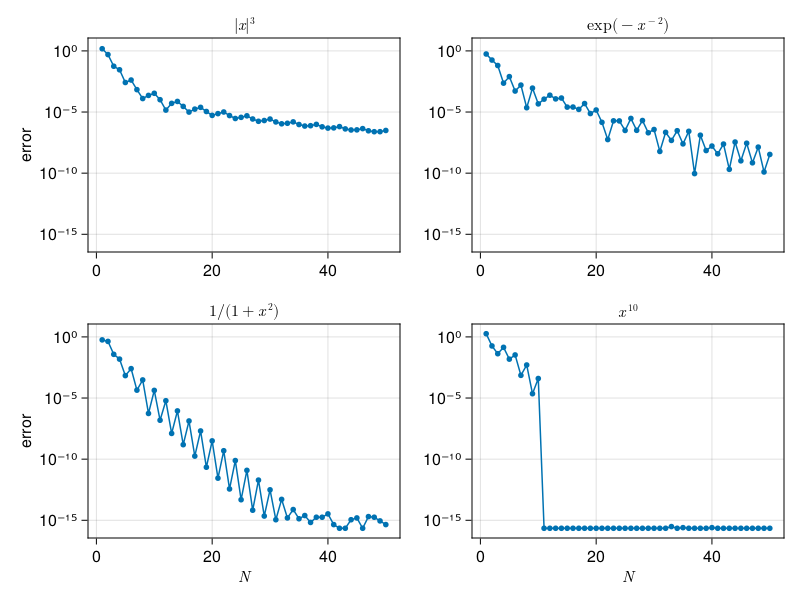

In [3]:
using CairoMakie

fig = Figure()
ax = [ Axis(fig[j,i], yscale=log10) for i in 1:2, j in 1:2 ]
for (ax,r) in zip(vec(ax),results)
    ax.title = r.title
    scatterlines!(ax, N, max.(eps(),r.E), markersize=8)
end
linkxaxes!(ax...)
linkyaxes!(ax...)
ax[1,2].xlabel = ax[2,2].xlabel = L"N"
ax[1,1].ylabel = ax[1,2].ylabel = "error"
fig

## Clenshaw--Curtis

Instead, we will return to and adapt the derivation of spectral collocation:

1. Interpolate $f$ by a polynomial $p$ of degree at most $N$ at $N+1$ nodes.
2. Use $I\approx \int_{-1}^1 p(x)\, dx$.

This does not give quite the same result as solving the IVP above; there, we interpolate $u$ on $N+1$ points and therefore represent $u'=f$ by a polynomial of degree less than $N$. Due to the linearity of polynomial interpolation, it yields a formula in the form

$$
I \approx \bfw^T \bff, 
$$

where $\bff$ is the vector of $N+1$ values of $\bff$, and $\bfw$ is a constant vector that, along with the interpolation nodes, characterizes the method.

If we use Chebyshev nodes to interpolate $f$, we get **Clenshaw--Curtis** integration.

In [4]:
function clencurt(N)
    θ = [ j*π / N for j in 0:N ]
    x = cos.(θ)
    w = zeros(N+1)
    θ = θ[2:N]
    v = ones(N-1)
    if iseven(N)
        w[1] = w[N+1] = 1 / (N^2 - 1)
        for k in 1:div(N,2)-1
            @. v -= 2cos(2k * θ) / (4k^2 - 1)
        end
        @. v -= cos(N*θ) / (N^2 - 1)
    else
        w[1] = w[N+1] = 1 / N^2
        for k in 1:div(N-1,2)
            @. v -= 2cos(2k * θ) / (4*k^2 - 1)
        end
    end
    @. w[2:N] = 2v / N
    return x, w
end;

### p30b: spectral integration, Clenshaw--Curtis

In [5]:
results = []
for (i, (f,I,title)) in enumerate(data)
    E = zeros(length(N))
    for (k,N) in enumerate(N)
        x, w = clencurt(N)
        E[k] = abs(dot(w,f.(x)) - I)
    end
    push!(results, (;E, title))
end

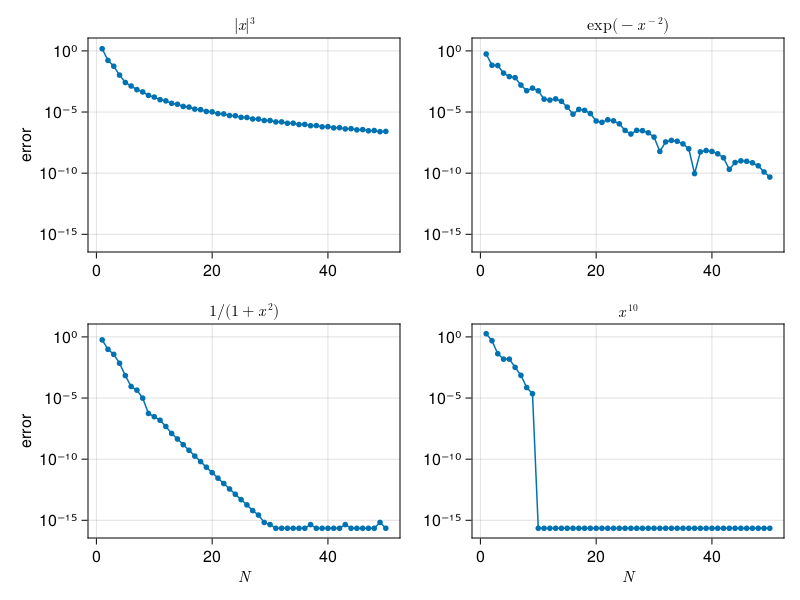

In [6]:
fig = Figure()
ax = [ Axis(fig[j,i], yscale=log10) for i in 1:2, j in 1:2 ]
for (ax,r) in zip(vec(ax),results)
    ax.title = r.title
    scatterlines!(ax, N, max.(eps(),r.E), markersize=8)
end
linkxaxes!(ax...)
linkyaxes!(ax...)
ax[1,2].xlabel = ax[2,2].xlabel = L"N"
ax[1,1].ylabel = ax[1,2].ylabel = "error"
fig

## Gaussian integration

Somewhat surprisingly, we can do even better than the spectral convergence of Clenshaw--Curtis. By taking the nodes to be roots of Legendre polynomials rather than extreme points of Chebyshev polynomials, we get a **Gaussian integration** formula. As long as we don't need hundreds of nodes, this is easy to accomplish in practice.

In [7]:
function gauss(N)
    β = [ .5 / sqrt(1 - 1/(2*i)^2) for i in 1:N-1 ]
    T = diagm(1=>β, -1=>β)
    x, V = eigen(T)
    w = 2V[1,:].^2
    return x, w
end;

Gaussian integration on $N+1$ nodes is exact for integrands of degree up to $2N-1$, not just $N$.

### p30c: spectral integration, Gauss

In [8]:
results = []
for (i, (f,I,title)) in enumerate(data)
    E = zeros(length(N))
    for (k,N) in enumerate(N)
        x, w = gauss(N)
        E[k] = abs(dot(w,f.(x)) - I)
    end
    push!(results, (;E, title))
end

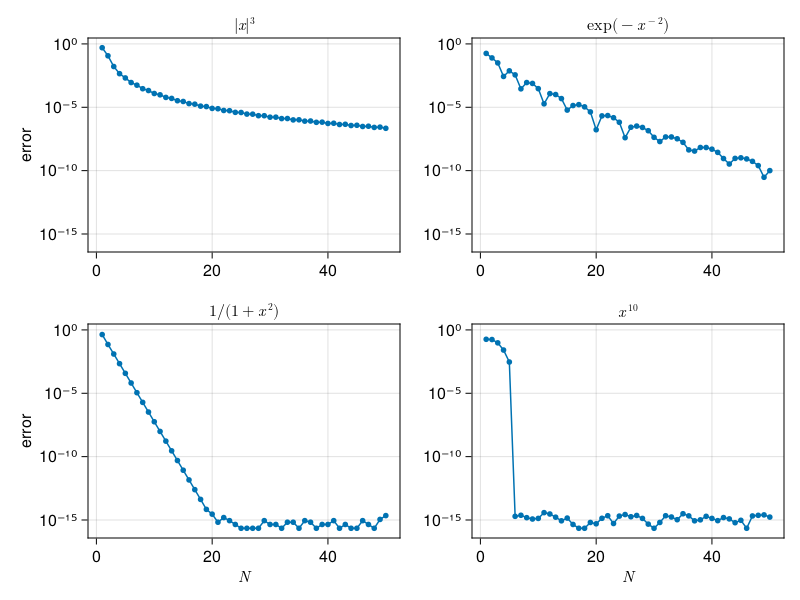

In [9]:
fig = Figure()
ax = [ Axis(fig[j,i], yscale=log10) for i in 1:2, j in 1:2 ]
for (ax,r) in zip(vec(ax),results)
    ax.title = r.title
    scatterlines!(ax, N, max.(eps(),r.E), markersize=8)
end
linkxaxes!(ax...)
linkyaxes!(ax...)
ax[1,2].xlabel = ax[2,2].xlabel = L"N"
ax[1,1].ylabel = ax[1,2].ylabel = "error"
fig

Gaussian integration is important in applications that rely heavily on integrals, notably Galerkin methods based on weak formulations of PDEs. For collocation, though, Chebyshev points perform as well and are more convenient, particularly for their connection to the FFT.

## Periodic integrands

If $f$ is $2\pi$-periodic, then we can represent it as a Fourier series, and the integral over one period cancels out all but the constant term, 

$$
I \approx 2\pi \left( \frac{1}{2\pi} \hat{f}_0 \right) = h \sum_{j=1}^N f_j. 
$$

This is the same value we get if we apply the standard (composite) trapezoid formula to $f$ over $[0,2\pi]$, keeping in mind that $f_0=f_N$. Thus, the trapezoid formula is spectrally accurate on smooth, periodic integrands!

For example, the perimeter of an ellipse with axes 2 and 1 can be computed as an arc-length integral,

$$
\int_0^{2\pi} \sqrt{ \cos^2 \theta + \tfrac{1}{4}\sin^2\theta }\, d\theta. 
$$

In [10]:
perim(N) = 2π/N * sum( sqrt(cos(θ)^2 + sin(θ)^2/4) for θ in 2π/N*(1:N) )
[ perim(N) for N in 19:2:29 ]

6-element Vector{Float64}:
 4.84422411030053
 4.844224110276384
 4.844224110274085
 4.844224110273863
 4.844224110273839
 4.844224110273838

One application is integrals over smooth, closed contours of the complex plane. For example, the gamma function satisfies

$$
\frac{1}{\Gamma(z)} \approx \frac{1}{2\pi} \int_0^{2\pi} e^t t^{-z} (t-c) \, d\theta,
$$

where $t = c + re^{i\theta}$ is chosen to intersect the real axis far from the origin.

### p31 - gamma function via complex integral, trapezoid rule

In [11]:
N = 70
c, r = -11, 16
θ = [ -π + (j-0.5)*(2π / N) for j in 1:N ]
x = range(-3.5, 4, 120)
y = range(-2.5, 2.5, 100)
t = @. c + r*cis(θ)
G = [ sum( exp(t) * t^(-x - 1im*y) * (t-c) for t in t ) for x in x, y in y ]
Γ = N ./ G;

The following plot uses contours equally spaced in $\log |\Gamma(z)|$ and a cyclic color map to indicate the argument of $\Gamma(z)$:

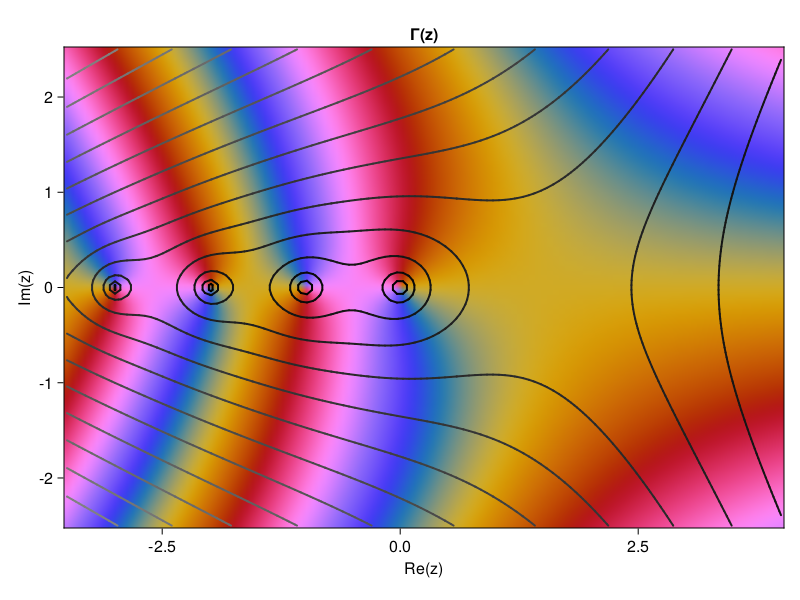

In [12]:
using Makie.Colors

fig = Figure()
ax = Axis(fig[1, 1], aspect=DataAspect(), 
    xlabel="Re(z)", ylabel="Im(z)", title="Γ(z)")
heatmap!(x,y,angle.(Γ),colormap=:cyclic_mrybm_35_75_c68_n256,interpolate=true)
blacks = Gray.(range(0.5, 0, 13))
contour!(x,y,log10.(abs.(Γ)), levels=13, color=blacks, linewidth=2)
fig